# <span style="color: #674172">Mask detection</span>
### <span style="color: #674172">using Prajna Bhandary <a href=https://www.kaggle.com/chandrasekarank/prajna-bhandary-face-mask-detection-dataset>dataset</a> and Adrian Rosebrock <a href=https://towardsdatascience.com/a-complete-anomaly-detection-algorithm-from-scratch-in-python-step-by-step-guide-e1daf870336e>tutorial</a></span>

## <span style="color: #674172">Part 1. Detection model with base dataset</span>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

%matplotlib inline

## <span style="color: #674172">0. Dataset</span>

In [2]:
# Create a list of all dataset images paths

image_paths = []

for path, subdirs, files in os.walk('.\\data\\'):
    for name in files:
        image_paths.append(os.path.join(path, name))

In [3]:
# Load images, turn them into scaled arrays and create labels list

data = []
labels = []

for image_path in image_paths:
    
    label = image_path.split(os.path.sep)[-2]
    labels.append(label)
    
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)

data = np.array(data, dtype='float32')
labels = np.array(labels)  

In [4]:
# Translate labels into one-hot encoding

label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

In [5]:
# Split dataset into train and test subsets

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=13)

## <span style="color: #674172">1. Model compilation</span>

In [6]:
# Construct image generator to randomly alter training images 
# (data augmentation to increase model generalization abilities)

augment = ImageDataGenerator(rotation_range=20,
                             zoom_range=0.20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.15,
                             horizontal_flip=True,
                             fill_mode='nearest')


In [7]:
# Load MobileNetV2 base model with pre-trained ImageNet weights with top fully connected layer excluded

base_model = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_tensor=Input(shape=(224, 224, 3)))

C:\Users\Sveta\anaconda3\envs\cv_env\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [8]:
# Construct the head of the model to put on top of the base model

head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

In [9]:
# Assemble model from the base and the head and freeze all the layers of the base model
# so only the layers on top will be trained (fine tuning)

model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers:
    layer.trainable = False

In [10]:
# Compile model

learning_rate = 0.0001
number_of_epochs = 20
batch_size = 32

opt = Adam(learning_rate=learning_rate, decay=learning_rate / number_of_epochs)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

## <span style="color: #674172">2. Model training</span>

In [11]:
# Train model

# H = model.fit(augment.flow(X_train, y_train, batch_size=batch_size),
#               steps_per_epoch=len(X_train) // batch_size,
#               validation_data=(X_test, y_test),
#               validation_steps=len(X_test) // batch_size,
#               epochs=number_of_epochs)

  ...
    to  
  ['...']
Train for 34 steps, validate on 276 samples
Epoch 1/20
34/34 [==============================] - 106s 3s/step - loss: 0.6717 - accuracy: 0.6255 - val_loss: 0.3579 - val_accuracy: 0.8789
Epoch 2/20
34/34 [==============================] - 106s 3s/step - loss: 0.4159 - accuracy: 0.8052 - val_loss: 0.2239 - val_accuracy: 0.9570
Epoch 3/20
34/34 [==============================] - 107s 3s/step - loss: 0.3117 - accuracy: 0.8811 - val_loss: 0.1623 - val_accuracy: 0.9531
Epoch 4/20
34/34 [==============================] - 110s 3s/step - loss: 0.2577 - accuracy: 0.9081 - val_loss: 0.1228 - val_accuracy: 0.9688
Epoch 5/20
34/34 [==============================] - 104s 3s/step - loss: 0.2068 - accuracy: 0.9242 - val_loss: 0.1049 - val_accuracy: 0.9727
Epoch 6/20
34/34 [==============================] - 104s 3s/step - loss: 0.1864 - accuracy: 0.9307 - val_loss: 0.1043 - val_accuracy: 0.9766
Epoch 7/20
34/34 [==============================] - 102s 3s/step - loss: 0.1841 - acc

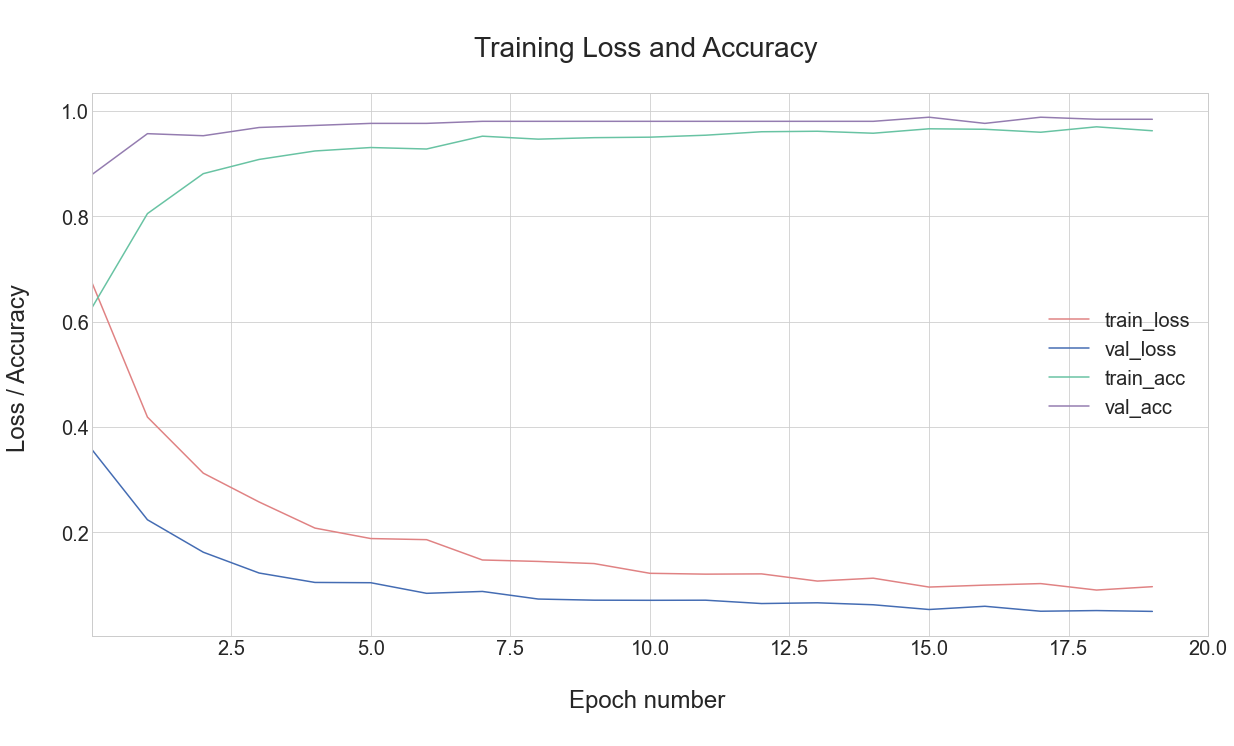

In [18]:
# Plot learning curves

plt.style.use('seaborn-whitegrid')
plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0.01, number_of_epochs)
plt.plot(np.arange(0, number_of_epochs), H.history['loss'], label='train_loss', color='#e08283')
plt.plot(np.arange(0, number_of_epochs), H.history['val_loss'], label='val_loss', color='#446cb3')
plt.plot(np.arange(0, number_of_epochs), H.history['accuracy'], label='train_acc', color='#68c3a3')
plt.plot(np.arange(0, number_of_epochs), H.history['val_accuracy'], label='val_acc', color='#947cb0')
plt.title('\nTraining Loss and Accuracy \n', fontsize=28)
plt.xlabel('\nEpoch number \n', fontsize=24)
plt.ylabel('Loss / Accuracy \n', fontsize=24)
plt.legend(loc='center right', fontsize=20);

In [17]:
# Predict and show classification report

prediction = model.predict(X_test, batch_size=batch_size)
prediction = np.argmax(prediction, axis=1)
print(classification_report(y_test.argmax(axis=1), 
                            prediction, 
                            target_names=label_binarizer.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       138
without_mask       0.99      0.98      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



In [14]:
# Save model for further use

model.save('.\\model\\model', save_format='h5')